# Compare crop yields to observations

- Uses raw annual CTSM outputs (NOT timeseries files).

Notebook created by Sam Rabin (samrabin@ucar.edu).

In [1]:
import sys
import os
import glob
import numpy as np
import xarray as xr
from time import time
from dask.distributed import Client, wait
import convert_pft1d_to_sparse
import importlib

# Plotting utils
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ctsm_python_gallery_path = (
    "/glade/work/samrabin/cupid_crops/externals/ctsm_python_gallery/ctsm_py"
)
sys.path.append(ctsm_python_gallery_path)
import utils

In [2]:
# Start a local Dask cluster using all available cores
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/samrabin/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/samrabin/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42243,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/samrabin/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:37985,Total threads: 2
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/samrabin/proxy/45693/status,Memory: 32.00 GiB
Nanny: tcp://127.0.0.1:40699,


## 1. Settings

### 1.1 Parameters modifiable in config.yml

In [3]:
# Where land output is stored
CESM_output_dir = os.path.join(
    os.path.sep,
    "glade",
    "work",
    "samrabin",
)

# Full casenames that are present in CESM_output_dir and in individual filenames
# caseNames = [
#             'b.e23_alpha16b.BLT1850.ne30_t232.054',
# 'b.e30_beta02.BLT1850.ne30_t232.104',
#             ]
case_name_list = None
case_name = "ctsm53019_f09_BNF_hist"

clm_file_h = ".h5."

cfts_to_include = [
    "temperate_corn",
    "tropical_corn",
    "cotton",
    "rice",
    "temperate_soybean",
    "tropical_soybean",
    "sugarcane",
    "spring_wheat",
    "irrigated_temperate_corn",
    "irrigated_tropical_corn",
    "irrigated_cotton",
    "irrigated_rice",
    "irrigated_temperate_soybean",
    "irrigated_tropical_soybean",
    "irrigated_sugarcane",
    "irrigated_spring_wheat",
]

crops_to_include = [
    "corn",
    "cotton",
    "rice",
    "soybean",
    "sugarcane",
    "wheat",
]

dev_mode = True
verbose = True

In [4]:
# Parameters
case_name = "ctsm53019_f09_BNF_hist"
base_case_name = "b.e23_alpha17f.BLT1850.ne30_t232.092"
CESM_output_dir = "/glade/work/samrabin"
start_date = "0001-01-01"
end_date = "0101-01-01"
base_start_date = "0001-01-01"
base_end_date = "0101-01-01"
lc_kwargs = {"threads_per_worker": 1}
serial = False
clmFile_h = ".h5."
fluxnet_comparison = True
obsDir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data/lnd/analysis_datasets/ungridded/timeseries/FLUXNET2015/"
dev_mode = False
verbose = False
subset_kwargs = {}
product = "/glade/work/samrabin/cupid_crops/examples/crops/computed_notebooks//lnd/Global_crop_yield_compare_obs.ipynb"


### 1.2 Hard-coded settings

In [5]:
# Set up directory for any scratch output
if "SCRATCH" in os.environ:
    cupid_temp = os.path.join(os.environ["SCRATCH"], "CUPiD_scratch")
    os.makedirs(cupid_temp, exist_ok=True)
else:
    cupid_temp = "."

N_PFTS = 78

### 1.3 Process settings

In [6]:
if (case_name_list and case_name) or (not case_name_list and not case_name):
    raise RuntimeError("Specify one of caseNames or case_name")
if not case_name_list:
    case_name_list = [
        case_name,
    ]

short_names = [case.split(".")[-1] for case in case_name_list]

## 2. Import case data

### 2.1 Set up classes etc.

In [7]:
class Cft:
    def __init__(self, name, cft_num):
        self.name = name

        # 1-indexed in the FORTRAN style
        self.cft_num = cft_num
        self.pft_num = None  # Need to know max cft_num

        # 0-indexed in the Python style
        self.pft_ind = None  # Need to know pft_num
        self.where = None

    def __str__(self):
        return "\n".join(
            [
                self.name + ":",
                f"   cft_num: {self.cft_num}",
                f"   pft_num: {self.pft_num}",
                f"   pft_ind: {self.pft_ind}",
                f"   N cells: {len(self.where)}",
            ]
        )

    def update_pft(self, n_non_crop_pfts):
        """
        You don't know n_non_crop_pfts until after reading in all CFTs, so
        this function gets called once that's done in CftList.__init__().
        """
        self.pft_num = n_non_crop_pfts + self.cft_num - 1
        self.pft_ind = self.pft_num - 1

    def get_where(self, ds):
        """
        Get the indices on the pft dimension corresponding to this CFT
        """
        if self.pft_num is None:
            raise RuntimeError(
                "get_where() can't be run until after calling Crop.update_pft()"
            )
        pfts1d_itype_veg = ds["pfts1d_itype_veg"]
        if "time" in pfts1d_itype_veg.dims:
            pfts1d_itype_veg = pfts1d_itype_veg.isel(time=0)
        self.where = np.where(pfts1d_itype_veg.values == self.pft_num)[0].astype(int)
        return self.where


class CftList:
    def __init__(self, ds, n_pfts, cfts_to_include):
        # Get list of all possible CFTs
        self.cft_list = []
        for i, (key, value) in enumerate(ds.attrs.items()):
            if not key.startswith("cft_"):
                continue
            cft_name = key[4:]
            self.cft_list.append(Cft(cft_name, value))

        # Ensure that all CFTs in cfts_to_include are present
        cfts_in_file = [x.name for x in self.cft_list]
        missing_cfts = [x for x in cfts_to_include if x not in cfts_in_file]
        if missing_cfts:
            msg = (
                "The following are in cfts_to_include but not the dataset: "
                + ", ".join(missing_cfts)
            )
            raise KeyError(msg)

        # Figure out PFT indices
        max_cft_num = max([x.cft_num for x in self.cft_list])
        n_non_crop_pfts = n_pfts - max_cft_num + 1  # Incl. unvegetated
        for cft in self.cft_list:
            cft = cft.update_pft(n_non_crop_pfts)

        # Only include CFTs we care about
        if len(cfts_to_include) != len(np.unique(cfts_to_include)):
            raise ValueError("Duplicate CFT(s) in cfts_to_include")
        self.cft_list = [x for x in self.cft_list if x.name in cfts_to_include]

        # Figure out where the pft index is each CFT
        for cft in self.cft_list:
            cft.get_where(ds)
            if len(cft.where) == 0:
                print("Warning: No occurrences found of " + cft.name)

    def __getitem__(self, index):
        return self.cft_list[index]

    def __str__(self):
        results = []
        for cft in self.cft_list:
            results.append(str(cft))
        return "\n".join(results)


def get_cft_ds(ds, cft):
    ds = ds.isel(pft=cft.where)
    ds["cft"] = cft.pft_num
    ds = ds.set_coords("cft")
    for var in ds:
        if "pft" in ds[var].dims:
            ds[var] = ds[var].assign_coords(cft=cft.pft_num)
            ds[var] = ds[var].expand_dims("cft")
    return ds


class Crop:
    def __init__(self, name, cft_list, ds):
        self.name = name

        # Get CFTs included in this crop
        self.cft_list = []
        for cft in cft_list:
            if self.name not in cft.name:
                continue
            self.cft_list.append(cft)

        # Get information for all CFTs in this crop
        self.cft_names = []
        self.pft_nums = []
        self.pft_inds = []
        self.where = np.array([], dtype=np.int64)
        for cft in self.cft_list:
            self.cft_names.append(cft.name)
            self.pft_nums.append(cft.pft_num)
            self.pft_inds.append(cft.pft_ind)
            self.where = np.append(self.where, cft.get_where(ds))
        self.where = np.sort(self.where)

    def __str__(self):
        return f"{self.name}: {', '.join(f'{x.name} ({x.pft_num})' for x in self.cft_list)}"


class CropList:
    def __init__(self, crops_to_include, cft_list, ds):
        if len(crops_to_include) != len(np.unique(crops_to_include)):
            raise ValueError("Duplicate crop(s) found in crops_to_include")
        self.crop_list = [Crop(x, cft_list, ds) for x in crops_to_include]

    def __getitem__(self, index):
        if isinstance(index, str):
            found = False
            for i, crop in enumerate(self.crop_list):
                found = crop.name == index
                if found:
                    break
            if not found:
                raise KeyError(f"No crop found matching '{index}'")
            return self.crop_list[i]
        return self.crop_list[index]

    def __str__(self):
        results = []
        for crop in self.crop_list:
            results.append(str(crop))
        return "\n".join(results)


def mf_preproc(ds):
    ds["pfts1d_wtgcell"] = ds["pfts1d_wtgcell"].expand_dims(
        dim="time", axis=0
    )  # .assign_coords({"time": ds["time"]})
    return ds


class Case:
    def __init__(
        self, name, CESM_output_dir, clm_file_h, cfts_to_include, crops_to_include
    ):
        # Get list of necessary time series files
        file_dir = os.path.join(
            CESM_output_dir,
            name,
            "lnd",
            "hist",
        )
        file_pattern = os.path.join(file_dir, name + ".clm2" + clm_file_h + "*.nc")
        self.file_list = np.sort(glob.glob(file_pattern))
        if len(self.file_list) == 0:
            raise FileNotFoundError("No files found matching pattern: " + file_pattern)

        # Read files
        # Adding join="override", compat="override", coords="minimal", doesn't fix the graph size
        # Adding combine="nested", concat_dim="time" doesn't give time axis to only variables we want
        ds = xr.open_mfdataset(
            self.file_list,
            decode_times=True,
            chunks={},
            join="override",
            compat="override",
            coords="minimal",
            # combine="nested", concat_dim="time",
            data_vars="minimal",
            preprocess=mf_preproc,
        )

        # Get CFT info
        self.cft_list = CftList(ds, N_PFTS, cfts_to_include)

        # Get crop list
        self.crop_list = CropList(crops_to_include, self.cft_list, ds)

        # Save CFT dataset
        for i, cft in enumerate(self.cft_list):
            this_cft_ds = get_cft_ds(ds, cft)
            if i == 0:
                self.cft_ds = this_cft_ds.copy()
                n_expected = self.cft_ds.sizes["pft"]
            else:
                # Check # of gridcells with this PFT
                n_this = this_cft_ds.sizes["pft"]
                if n_this != n_expected:
                    raise RuntimeError(
                        f"Expected {n_expected} gridcells with {cft.name}; found {n_this}"
                    )
                self.cft_ds = xr.concat(
                    [self.cft_ds, this_cft_ds],
                    dim="cft",
                    data_vars="minimal",
                    compat="override",
                    join="override",
                    coords="minimal",
                )

        # Load
        if dev_mode:
            if verbose:
                start = time()
                print("Loading...")
            self.cft_ds.load()
            if verbose:
                end = time()
                print(f"Loading took {int(end - start)} s")

### 2.2 Import cases

In [8]:
start = time()
case_list = []
for i, case in enumerate(case_name_list):
    print(f"Importing {case}...")
    case_list.append(
        Case(case, CESM_output_dir, clm_file_h, cfts_to_include, crops_to_include)
    )

print("Done.")
if verbose:
    end = time()
    print(f"Importing took {int(end - start)} s")

Importing ctsm53019_f09_BNF_hist...


Done.


## 3. Time series plots

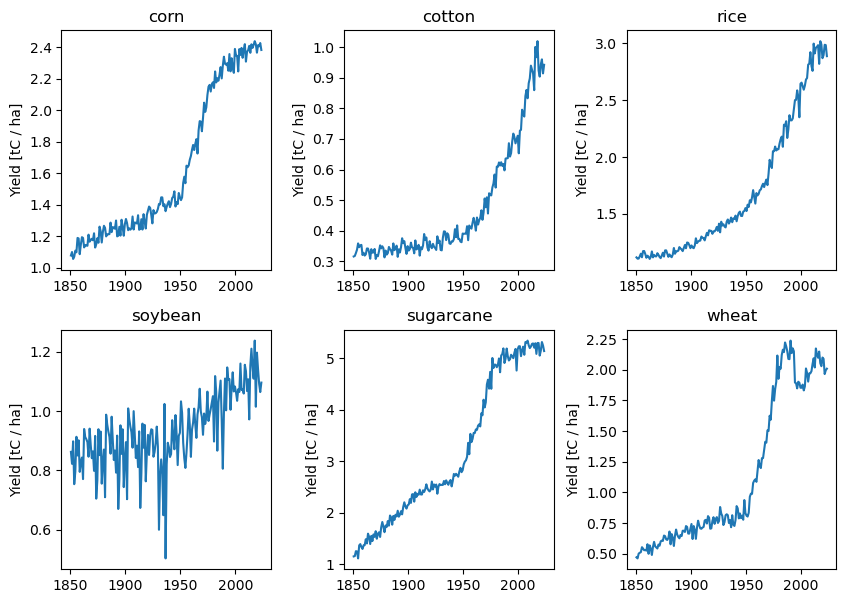

In [9]:
if verbose:
    start = time()

# ↓ Incorrectly assumes that all gridcells have the same area
gridcell_area = case_list[0].cft_ds["area"].mean() * 1e6  # *1e6 to convert km2 to m2

# Get figure layout info
if 5 <= len(crops_to_include) <= 6:
    nrows = 2
    ncols = 3
    height = 7
    width = 10
    hspace = 0.25
    wspace = 0.35
else:
    raise RuntimeError(f"Specify figure layout for Ncrops=={len(crops_to_include)}")
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height))

for i, crop in enumerate(crops_to_include):
    ax = axes.ravel()[i]
    plt.sca(ax)
    for case in case_list:
        ds = case.cft_ds.sel(cft=case.crop_list[crop].pft_nums)

        cft_area = gridcell_area * ds["pfts1d_wtgcell"]
        cft_prod = ds["GRAINC_TO_FOOD_ANN"] * cft_area
        crop_prod_ts = cft_prod.sum(dim=["cft", "pft"])
        crop_area_ts = cft_area.sum(dim=["cft", "pft"])
        crop_yield_ts = crop_prod_ts / crop_area_ts

        # Plot data
        crop_yield_ts *= 1e-6 * 1e4  # Convert gC/m2 to tC/ha
        crop_yield_ts.name = "Yield"
        crop_yield_ts.attrs["units"] = "tC / ha"
        crop_yield_ts.plot()

    # Finish plot
    ax.set_title(crop)
    plt.xlabel("")
plt.subplots_adjust(wspace=wspace, hspace=hspace)
plt.show()

if verbose:
    end = time()
    print(f"Time series plots took {int(end - start)} s")

## 4. Maps

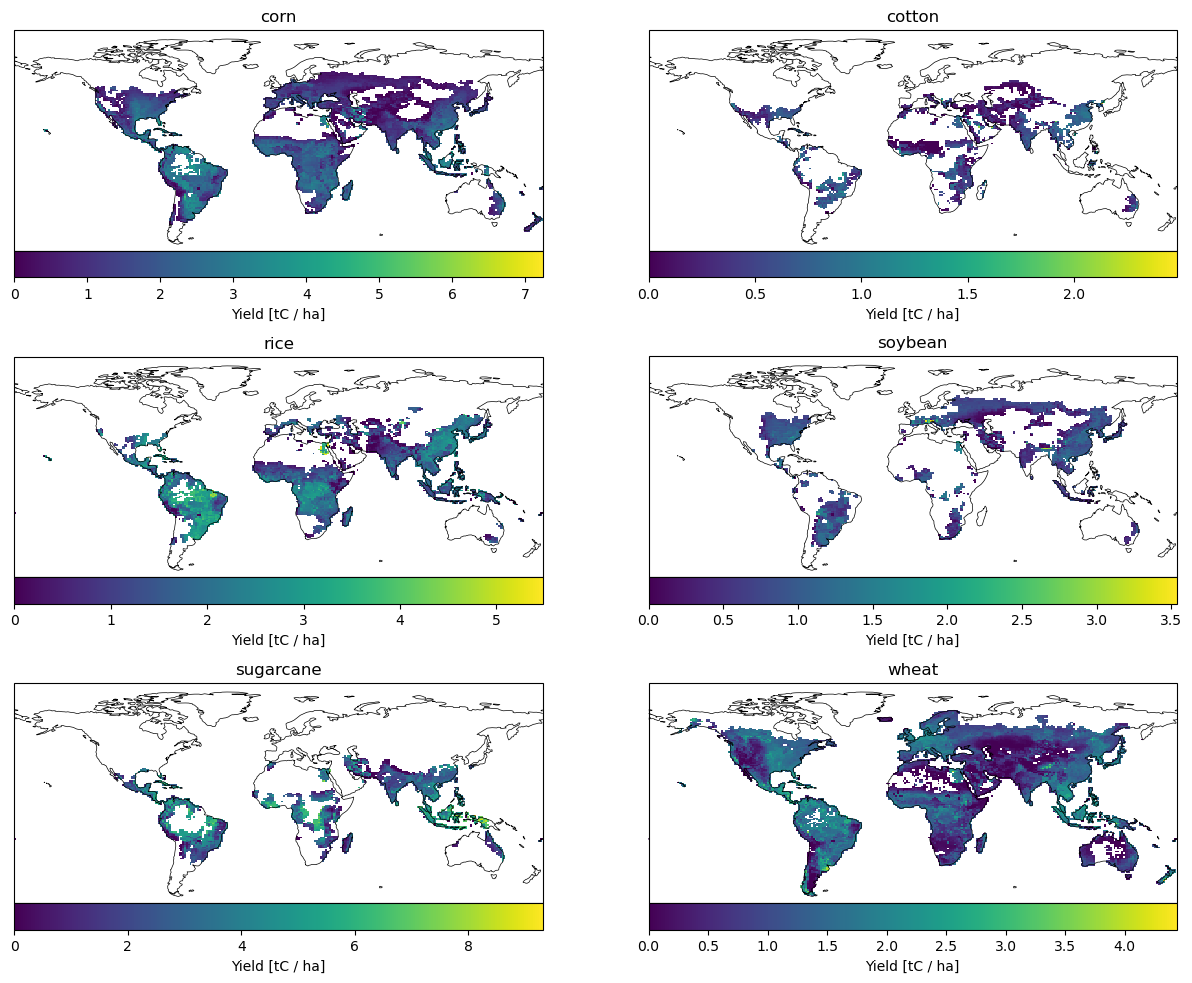

In [10]:
importlib.reload(utils)

# Get figure layout info
if 5 <= len(crops_to_include) <= 6:
    nrows = 3
    ncols = 2
    height = 12
    width = 15
    hspace = 2
    wspace = 0
else:
    raise RuntimeError(f"Specify figure layout for Ncrops=={len(crops_to_include)}")
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(width, height),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

if verbose:
    start_all = time()
for i, crop in enumerate(crops_to_include):
    ax = axes.ravel()[i]
    plt.sca(ax)
    if verbose:
        start = time()
        print(crop)
    for case in case_list:
        ds = case.cft_ds.sel(cft=case.crop_list[crop].pft_nums)
        ds = ds.drop_vars(["date_written", "time_written"])
        if verbose:
            print("getting mean across time")
        ds = ds.mean(dim="time")
        if verbose:
            print("getting CFT-weighted mean")
        ds["wtd_yield_across_cfts"] = (
            ds["GRAINC_TO_FOOD_ANN"].weighted(ds["pfts1d_wtgcell"]).mean(dim="cft")
        )
        if verbose:
            print("gridding yields")
        result = utils.grid_one_variable(ds, "wtd_yield_across_cfts")
        result = utils.lon_pm2idl(result)

        # Cut off Antarctica
        antarctica_border = -60
        if np.isnan(result.sel(lat=slice(-90, antarctica_border)).max()):
            result = result.sel(lat=slice(antarctica_border, 90))

        # Plot data
        result *= 1e-6 * 1e4  # Convert gC/m2 to tC/ha
        result.name = "Yield"
        result.attrs["units"] = "tC / ha"
        if verbose:
            print("plotting")
        result.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"location": "bottom", "pad": 0},
        )
        ax.coastlines(linewidth=0.5)
        plt.title(crop)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")
    end = time()
    if verbose:
        print(f"{crop} took {end - start} s")

plt.show()

if verbose:
    end_all = time()
    print(f"Maps took {int(end_all - start_all)} s.")